In [1]:
import numpy as np
from scipy.signal import fftconvolve

from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tsample = 0.005 / 1000
model = ec2b.TemporalModel(tsample)

stim_durs = np.linspace(0.05, 0.5, 11)
kernels = [model.gamma_nfl, model.gamma_ca, model.gamma_slow]
kernel_names = ['fast response', 'charge accumulation', 'slow response']

In [3]:
t_cpu = np.zeros((len(kernels), len(stim_durs)))
t_gpu_mem = np.zeros((len(kernels), len(stim_durs)))
t_gpu_nomem = np.zeros((len(kernels), len(stim_durs)))

for k, kernel in enumerate(kernels):
    print("Running kernel %d" % k)
    for d, dur in enumerate(stim_durs):
        arrsize = int(np.round(dur / tsample))
        pt = np.random.rand(arrsize)
    
        # CUDA FFT needs to be initialized with right array sizes
        cu = utils.CuFFTConvolve(arrsize, kernel.size)
    
        # As fast as it goes with scipy
        tc = %timeit -oq -n3 -r10 fftconvolve(pt, kernel)
        
        # Using CUDA FFT, including memcpy
        tg = %timeit -oq -n3 -r10 cu.cufftconvolve(pt, kernel, dtoh=True)
        
        # Using CUDA FFT, pre-initialzied kernel, no memcpy
        tm = %timeit -oq -n3 -r10 cu.cufftconvolve(pt, None, dtoh=False)
    
        t_cpu[k, d] = tc.best
        t_gpu_mem[k, d] = tg.best
        t_gpu_nomem[k, d] = tm.best

Running kernel 0
Running kernel 1
Running kernel 2


Populating the interactive namespace from numpy and matplotlib


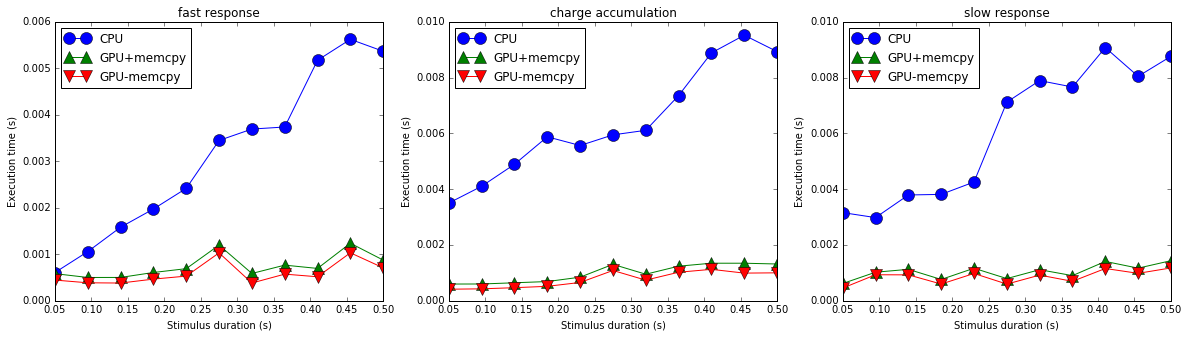

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 5)

for k, _ in enumerate(kernels):
    plt.subplot(1, len(kernels), k + 1)
    
    plt.plot(stim_durs, t_cpu[k, :], '-o', label='CPU', markersize=12)
    plt.plot(stim_durs, t_gpu_mem[k, :], '-^', label='GPU+memcpy', markersize=12)
    plt.plot(stim_durs, t_gpu_nomem[k, :], '-v', label='GPU-memcpy', markersize=12)
    plt.title(kernel_names[k])
    plt.xlabel('Stimulus duration (s)')
    plt.ylabel('Execution time (s)')
    plt.legend(loc='upper left')